# FRC算法流程
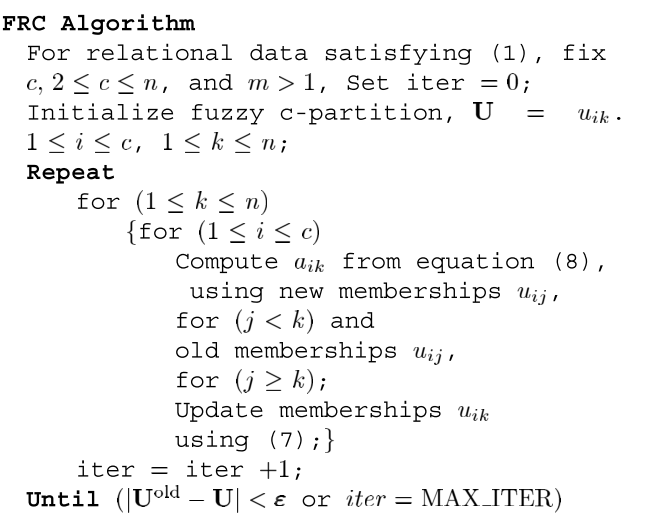

# 代码

In [3]:
import numpy as np
import pandas as pd

In [4]:
def loadData(dataSet='CD', convertMethod=0):
    """
    函数功能： 生成关系型数据
        参数:
            convertMethod: 当dataSet != CD时起效果
                0: 使用Dij = 1 / Sij - min(1/Srt)转化
                1: 使用Dij = max(Str) - Sij转化
        返回:(id2name, R) 
            id2name: map
            R: (n, n) 
    """
    if dataSet == 'CD':
        path = './data/CD.csv'
    elif dataSet == 'FAT':
        path = './data/FAT.csv'
    else:
        path = './data/COMP.csv'
    R = []
    with open(path, 'r') as f:
        lines = f.readlines()
        names = lines[0].strip().split(',')
        id2name = {i:each for i, each in enumerate(names)}
        for line in lines[1:]:
            R.append(list(map(lambda x: float(x), line.strip().split(','))))
    R = np.array(R)
    if dataSet == 'CD':
        return id2name, R
    if convertMethod == 0:
        R = 1/R-np.min(1/R)
    else:
        R = np.max(R) - R
    # print(R)
    return id2name, R

In [5]:
def plotResult(id2country, U):
    """
    函数功能：可视化结果，如表V所示
    传入参数:
        id2country:（map)
        U：隶属度矩阵, (c, n)
    """
    c, n = U.shape

    Ut = U.T
    belongsTo = np.argmax(Ut, 1)
    countrys = [id2country[i] for i in range(n)]
    countrysAndtype = [item for item in list(zip(countrys, belongsTo))]
    Result = np.concatenate([Ut, belongsTo[:,np.newaxis]], axis=1)
    Result = sorted(Result, key=lambda x:x[c])
    countrysAndtype = sorted(countrysAndtype,key=lambda x:x[1])
    
    index = [i[0] for i in countrysAndtype]
    columns = ["Cluster {}".format(i) for i in range(c)]
    columns.append('Belongs to Cluster')
    df = pd.DataFrame(Result, index=index, columns=pd.Index(columns))
    return df

In [6]:
def init(c, n):
    """
    函数功能: 初始化隶属程度矩阵U, 其中Uik代表样本k属于第i类的概率
    参数:
        n: 样本数
        c: 类别数
    返回:
        U:(c,n), 其中sum{Uij,0=j<n} = 1
    """
    return np.random.dirichlet(np.ones(n),size=c)

In [264]:
def updateUOfFrc(Uold, R, m, lam=None):
    """
    函数功能，实现式(7),(8),更新U
    参数:
        U:(c,n). 隶属度矩阵
        R:(n,n). 关系矩阵
        m: 模糊指数
    返回
        U:(c,n).更新后的U
    """
    c, n = Uold.shape
    U = Uold.copy()
    "步骤1：初始化A"
    A = np.ones([c, n])
    for k in range(n):
        for i in range(c):
            Ui_ = U[i,:]
            R_k = R[:,k]
            firstNumerator = m * sum(Ui_**m * R_k)
            firstDenominator = sum(Ui_**m)
            
            secondNumerator = 0 
            for h in range(n):
                R_h = R[:,h]
                secondNumerator +=  sum(m * (Ui_**m) * (U[i][h]**m) * R_h)
            secondDenominator = 2 * (sum(Ui_ ** m) ** 2)
            A[i][k] = firstNumerator / firstDenominator - secondNumerator / secondDenominator
        "步骤2: 更新U"
        for k in range(n):
            for i in range(c):
                "步骤2.1:利用新的U更新A"
                Ui_ = U[i,:]
                R_k = R[:,k]
                firstNumerator = m * sum(Ui_**m * R_k)
                firstDenominator = sum(Ui_**m)

                secondNumerator = 0 
                for h in range(n):
                    R_h = R[:,h]
                    secondNumerator +=  sum(m * (Ui_**m) * (U[i][h]**m) * R_h)
                secondDenominator = 2 * (sum(Ui_ ** m) ** 2)
                A[i][k] = firstNumerator / firstDenominator - secondNumerator / secondDenominator

                "步骤2.2:计算U"
                exponent = 1/(m-1)
                numerator = (1/A[i][k]) ** exponent
                A_k = A[:,k]
                denominator = sum((1 / A_k) ** exponent)
                U[i][k] = numerator / denominator
    # print(sum(U))
    return U

In [364]:
def updateUOfRNeFrc(Uold, R, m, lam=0.1):
    """
    函数功能，实现式(7),(8),更新U
    参数:
        U:(c+1,n). 隶属度矩阵
        R:(n,n). 关系矩阵
        m: 模糊指数
        lam：计算噪声类的lambda， 一般为：0.1，对于CD:0.01
    返回
        U:(c+1,n).更新后的U
    """
    c, n = Uold.shape
    U = Uold.copy()  
    "步骤1：初始化A"
    A = np.ones([c, n])
    B = np.ones([c, n])
    for k in range(n):
        for i in range(c):
            Ui_ = U[i,:]
            R_k = R[:,k]
            firstNumerator = m * sum(Ui_**m * R_k)
            firstDenominator = sum(Ui_**m)
            
            secondNumerator = 0 
            for h in range(n):
                R_h = R[:,h]
                secondNumerator +=  sum(m * (Ui_**m) * (U[i][h]**m) * R_h)
            secondDenominator = 2 * (sum(Ui_ ** m) ** 2)
            A[i][k] = firstNumerator / firstDenominator - secondNumerator / secondDenominator
        "步骤2: 更新U"
        for k in range(n):
            for i in range(c):
                "步骤2.1:利用新的U更新A"
                Ui_ = U[i,:]
                R_k = R[:,k]
                firstNumerator = m * sum(Ui_**m * R_k)
                firstDenominator = sum(Ui_**m)

                secondNumerator = 0 
                for h in range(n):
                    R_h = R[:,h]
                    secondNumerator +=  sum(m * (Ui_**m) * (U[i][h]**m) * R_h)
                secondDenominator = 2 * (sum(Ui_ ** m) ** 2)
                A[i][k] = firstNumerator / firstDenominator - secondNumerator / secondDenominator

                "步骤2.2:计算U"
                exponent = 1/(m-1)
                numerator = (1/A[i][k]) ** exponent
                A_k = A[:,k]
                denominator = sum((1 / A_k) ** exponent)
                U[i][k] = numerator / denominator
                B[i][k] = A[i][k] * U[i][k] ** (m-2)
            
    print(sum(U))
    "步骤3：加入噪声类,利用(52)式计算"
    BstartK = (lam * sum(sum(B[:c-1])) / ((c-1) * n))
    BstartK = np.ones([1,n]) * BstartK
    # aStart = m * (delta / 2)
    # BstartK = aStart * (U[c-1] ** (m-2))
    # print(BstartK)
    # BstartK = BstartK[np.newaxis, :]
    # print("Bstartk {}".format(BstartK))
    B = np.concatenate([B[:c-1],BstartK], axis=0)  # (c, n)
    
    "步骤4：求Bij， 并求正集合"
    positive = []
    Ip = np.zeros([c, n])
    setFlagB = np.zeros([c, n])
    # print(B)
    for k in range(n):
        for i in range(c):
            setFlagB[i][k] = (1/B[i][k]) / sum(1/B[:,k])
            if setFlagB[i][k] <= 0:
                U[i][k] = 0
                print("have negetive")
            else:
                Ip[i][k] = B[i][k]
                positive.append([i,k])
    # print(positive)
    "步骤5：根据正集合更新U"
    # print(U)
    for i, k in positive:
        U[i][k] = (1/B[i][k]) / (sum(1 / Ip[:,k]))
    # print(sum(U))
    return U

In [371]:
def cluster(R, c,  m, epsilon, maxIterNum, updateMethod=updateUOfRNeFrc, lam=None):
    """
    函数功能： 实现聚类算法算法
    参数:
        U:(c,n). 隶属度矩阵
        R:(n,n). 关系矩阵
        m: 模糊指数
        c: 聚类数
        epsilon: 终止迭代的阈值
        maxIterNum: 最大迭代次数
        updateMethod:
            updateUOfFrc: FRC算法
            updateUOfRNeFrc: R_NE_FRC算法
        lam: updateUOfRNeFrc需要
    返回:
        U:(c/c+1, n): 最终的隶属度矩阵
    """
    
    "初始化隶属度矩阵"
    n = R.shape[0]
    if updateMethod == updateUOfRNeFrc:
        U = init(c+1, n)
    else:
        U = init(c, n)
    if updateMethod == updateUOfRNeFrc and lam == None:
        print("R_NE_FRC算法需要lam")
        return None
    
    for step in range(maxIterNum):
        Unew = updateMethod(U, R, m, lam)
        # print(sum(sum(Unew - U)))
        if abs(sum(sum(Unew - U))) < epsilon:
            if lam == None:
                print("FRC Algorithm, Get The Minmum in epoch {}".format(step))
            else:
                print("R_NE_FRC Algorithm, Get The Minmum in epoch {}".format(step))
            return Unew
        U = Unew
    return Unew
    

In [372]:
id2country, R = loadData(dataSet='CD', convertMethod=0)
c = 3
m = 2
epsilon = 1e-20
maxIterNum = 10
resultU = cluster(R, c, m, epsilon, maxIterNum=maxIterNum, updateMethod=updateUOfRNeFrc, lam=1)
#  resultU = cluster(R, c, m, epsilon, maxIterNum=maxIterNum, updateMethod=updateUOfFrc, lam=None)

[1.00006939 1.00012118 0.99861803 1.00308136 1.00010236 0.99965185
 0.99965943 0.99966225 0.99977703 1.00076288 0.99890208 0.99995701]
[1.00033004 1.00050786 0.9964027  1.0069435  1.00047342 0.99945145
 0.99904448 0.99973169 1.0002003  1.00279097 0.99676677 0.99990814]
[1.00036785 1.00077811 0.9958082  1.00830594 1.00054053 0.99941971
 0.99892622 0.99972502 1.00045134 1.00468082 0.99543544 1.00012563]
[1.00020316 1.0007967  0.99851226 0.99797818 1.00058944 0.99996501
 1.00064905 1.00019627 0.99992454 0.99766358 0.99856074 1.00066229]
[1.00077526 1.00014996 0.99880522 1.00076268 1.00049322 1.00022815
 0.99996663 1.00013469 1.00029699 0.99952304 0.99896077 1.00011284]
[1.00065511 1.00007932 0.99969634 1.00031802 1.00012393 1.00024903
 1.00013767 0.99987227 1.00008351 0.99972922 0.99968468 1.00013316]
[1.00065983 1.0000858  0.99972541 1.00029315 1.0001217  1.00026026
 1.0001577  0.9998705  1.00009162 0.99973525 0.99969907 1.0001317 ]
[1.0006645  1.00008985 0.9997308  1.00029011 1.00012408

In [373]:
plotResult(id2country, resultU)

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Belongs to Cluster
C1:Belgium,0.534203,0.185395,0.117367,0.163034,0.0
C6:France,0.528613,0.172775,0.124677,0.173935,0.0
C8:Israel,0.384225,0.229199,0.161463,0.225113,0.0
C9:USA,0.565719,0.173544,0.106576,0.154162,0.0
C2:Brazil,0.180625,0.465949,0.142677,0.210749,1.0
C5:Egypt,0.253253,0.307000,0.191072,0.248676,1.0
C7:India,0.189832,0.334458,0.210738,0.264972,1.0
C12:Zaire,0.175405,0.473378,0.145372,0.205844,1.0
C3:China,0.168345,0.217133,0.361531,0.252992,2.0
C4:Cuba,0.105449,0.136855,0.589597,0.168100,2.0


In [72]:
np.zeros(1,2)

TypeError: data type not understood